In [9]:
# take two weeks, 1 with worms, 1 without
# check if there is some nocturnal rhythm (worms are more active at night)
# run model for each picture to count worms
# output images with contours and make sure it is counting the worms correctly
# compare the two weeks
# take in sensor data like temperature, humidity, soil humidity, etc
# check if there is a correlation between the sensor data and the number of worms
# run the above for multiple weeks

In [10]:
import os
import zipfile
from tempfile import TemporaryDirectory
from inference import get_model
from PIL import Image
import roboflow
import pandas as pd
import supervision as sv
from inference import get_model
from PIL.ImageFile import ImageFile
import cv2
import seaborn as sns

In [11]:
worms_detected_count = pd.read_csv('./csv/worms_detected_count.csv')
worms_detected_count['date_time'] = pd.to_datetime(worms_detected_count['date_time'])
worms_detected_count

,image_name,num_worms,date_time,week_number
0,2024-08-26-00-00.jpg,0,2024-08-26 00:00:00,35
1,2024-08-26-00-10.jpg,0,2024-08-26 00:10:00,35
2,2024-08-26-00-20.jpg,0,2024-08-26 00:20:00,35
3,2024-08-26-00-30.jpg,0,2024-08-26 00:30:00,35
4,2024-08-26-00-40.jpg,0,2024-08-26 00:40:00,35
...,...,...,...,...
7895,2024-10-19-23-10.jpg,0,2024-10-19 23:10:00,42
7896,2024-10-19-23-20.jpg,0,2024-10-19 23:20:00,42
7897,2024-10-19-23-30.jpg,0,2024-10-19 23:30:00,42
7898,2024-10-19-23-40.jpg,0,2024-10-19 23:40:00,42


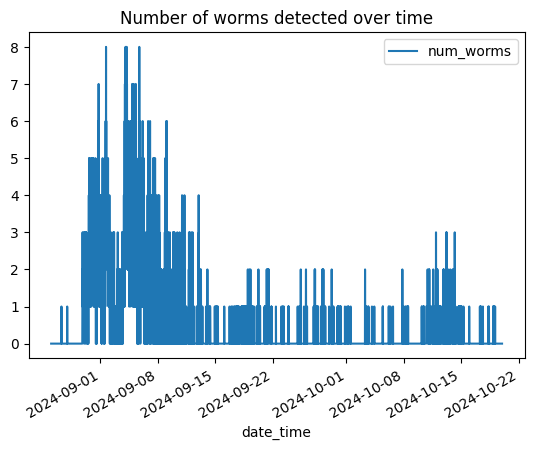

In [12]:
import matplotlib.pyplot as plt

worms_detected_count.plot(x='date_time', y='num_worms', kind='line', title='Number of worms detected over time')
plt.show()

## Nocturnal rhythm

Check if there is some nocturnal rhythm (worms are more active at night)

In [13]:
worms_per_hour = worms_detected_count.resample('h', on='date_time').agg({
    'num_worms': 'sum'
})

# Group by hour of the day and sum the number of worms detected
worms_per_hour['hour'] = worms_per_hour.index.hour
total_count_per_hour = worms_per_hour.groupby('hour')['num_worms'].sum().reset_index()

total_count_per_hour.head()

,hour,num_worms
0,0,184
1,1,231
2,2,240
3,3,179
4,4,190


<Axes: title={'center': 'Number of worms detected per hour'}, xlabel='date_time'>

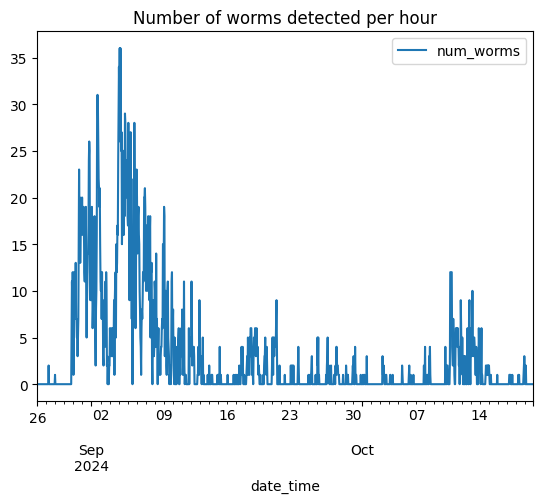

In [14]:
worms_per_hour.plot(y='num_worms', kind='line', title='Number of worms detected per hour')

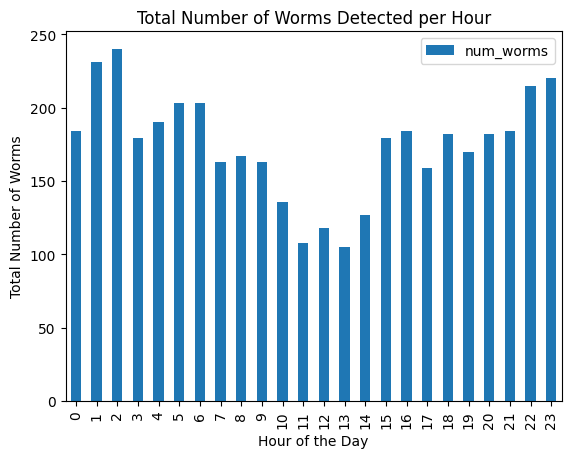

In [15]:
total_count_per_hour.plot(x='hour', y='num_worms', kind='bar', title='Total Number of Worms Detected per Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Total Number of Worms')
plt.show()

## Environment sensor data correlation

Check if there is correlation between number of worms and environment sensor data

### Load BME sensor data

In [16]:
bme680 = pd.read_csv('./csv/sensors/bme680.csv')
bme680['time'] = pd.to_datetime(bme680['time'])
bme680

,time,temperature,humidity,pressure,altitude
0,2024-04-26 21:23:20.575159,21.346797,51.301884,1004.731889,-65.218030
1,2024-04-26 21:24:42.906707,21.357539,51.271890,1004.722466,-65.138788
2,2024-04-26 21:25:42.916602,21.271602,51.135652,1004.734881,-65.243186
3,2024-04-26 21:26:42.931706,21.177266,51.186387,1004.767363,-65.516309
4,2024-04-26 21:27:42.947395,21.104219,51.183424,1004.789164,-65.699614
...,...,...,...,...,...
35935,2024-11-17 08:00:35.321367,10.278633,71.644334,1010.013515,-109.534999
35936,2024-11-17 09:00:35.316728,10.140742,67.565376,1010.198153,-111.080858
35937,2024-11-17 10:00:35.310046,10.383125,66.225411,1010.697705,-115.262153
35938,2024-11-17 11:00:35.311304,12.122383,56.856142,1010.830981,-116.377404


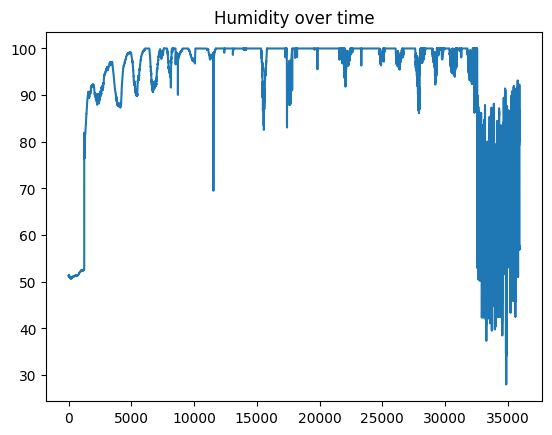

In [17]:
bme680['humidity'].plot(title='Humidity over time')
plt.show()

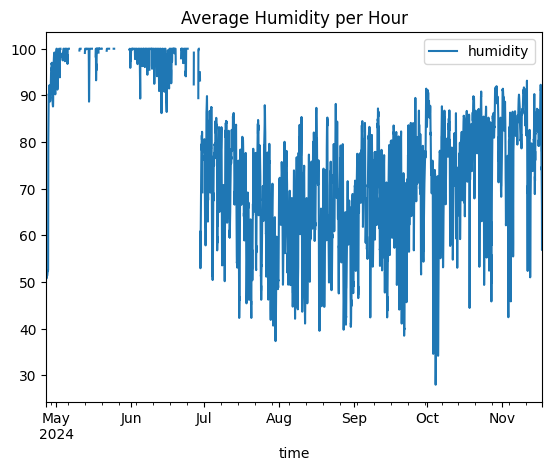

In [18]:
bme680_per_hour = bme680.resample('h', on='time').agg({
    'humidity': 'mean',
    'temperature': 'mean',
    'pressure': 'mean',
})

bme680_per_hour.plot(y='humidity', kind='line', title='Average Humidity per Hour')
plt.show()

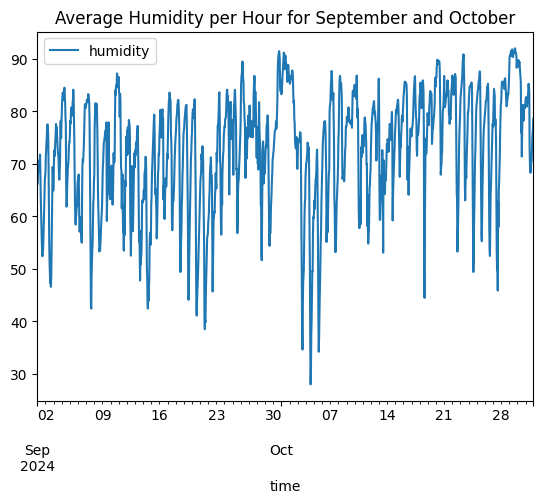

In [19]:
# Filter data for September and October
bme680_sept_oct = bme680_per_hour[(bme680_per_hour.index.month == 9) | (bme680_per_hour.index.month == 10)]

# Plot the filtered data
bme680_sept_oct.plot(y='humidity', kind='line', title='Average Humidity per Hour for September and October')
plt.show()

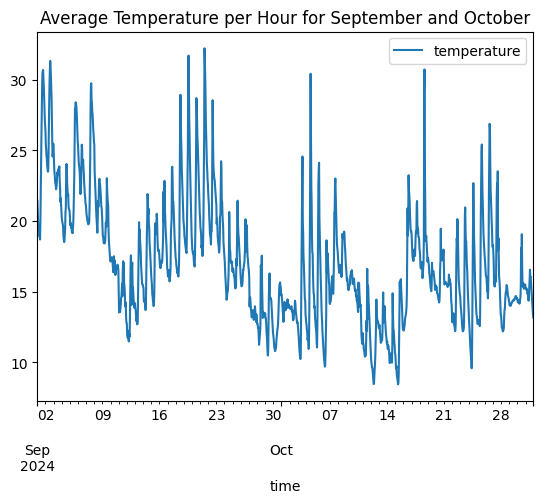

In [20]:
bme680_sept_oct.plot(y='temperature', kind='line', title='Average Temperature per Hour for September and October')
plt.show()

### Load soil moisture sensor data

In [21]:
soilMoisture = pd.read_csv('./csv/sensors/soil-moisture.csv')
soilMoisture['time'] = pd.to_datetime(soilMoisture['time'])
soilMoisture

,time,percentage,adc,dry_value,wet_value
0,2024-08-03 18:16:14.592709,69.36,9466,16700,6270
1,2024-08-03 19:00:52.116694,71.02,9293,16700,6270
2,2024-08-03 20:00:13.621421,72.38,9151,16700,6270
3,2024-08-03 21:00:39.533085,74.60,8919,16700,6270
4,2024-08-03 22:00:38.293196,76.23,8749,16700,6270
...,...,...,...,...,...
2534,2024-11-17 08:00:36.178800,100.00,4372,16700,6270
2535,2024-11-17 09:00:36.178763,100.00,4346,16700,6270
2536,2024-11-17 10:00:36.146536,100.00,4370,16700,6270
2537,2024-11-17 11:00:36.146674,100.00,4578,16700,6270


<Axes: title={'center': 'Soil Moisture over time'}, xlabel='time'>

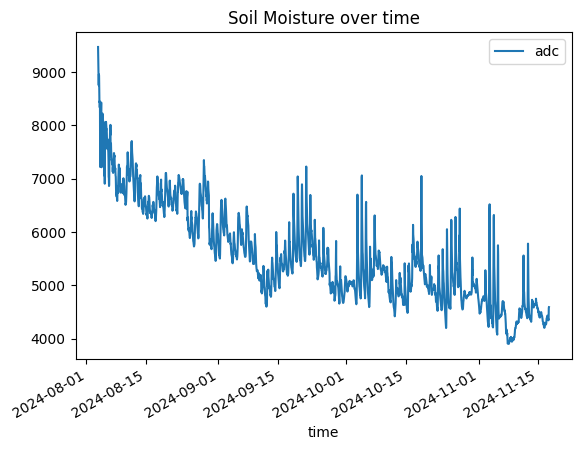

In [22]:
soilMoisture.plot(x='time', y='adc', title='Soil Moisture over time')

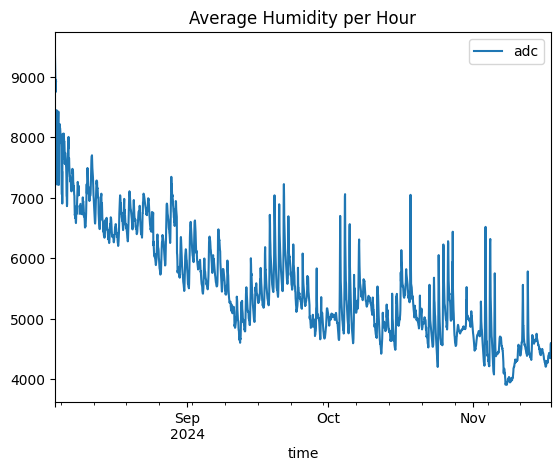

In [23]:
soilMoisture_per_hour = soilMoisture.resample('h', on='time').agg({
    'adc': 'mean',
})

soilMoisture_per_hour.plot(y='adc', kind='line', title='Average Humidity per Hour')
plt.show()

### Load soil temperature sensor data

In [24]:
soilTemperature = pd.read_csv('./csv/sensors/soil-temperature.csv')
soilTemperature['time'] = pd.to_datetime(soilTemperature['time'])
soilTemperature = soilTemperature.rename(columns={'temperature': 'soil_temperature'})
soilTemperature

,time,soil_temperature
0,2024-05-12 22:01:22.045164,24.8
1,2024-05-12 22:06:22.845158,24.7
2,2024-05-12 22:11:23.645309,24.7
3,2024-05-12 22:16:24.445170,24.7
4,2024-05-12 22:21:25.269179,24.7
...,...,...
9924,2024-11-17 08:00:36.145705,10.0
9925,2024-11-17 09:00:36.145693,9.9
9926,2024-11-17 10:00:36.113683,9.8
9927,2024-11-17 11:00:36.113683,10.9


<Axes: title={'center': 'Soil Temperature over time'}, xlabel='time'>

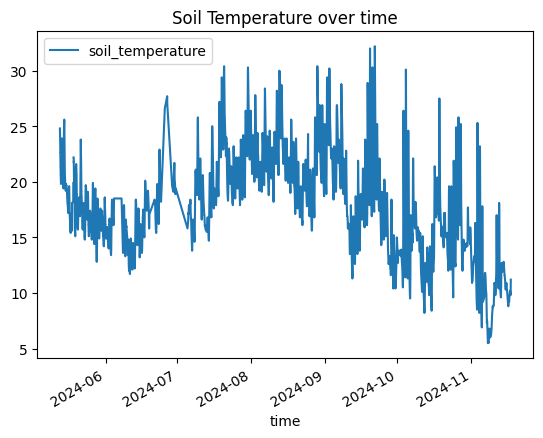

In [25]:
soilTemperature.plot(x='time', y='soil_temperature', title='Soil Temperature over time')

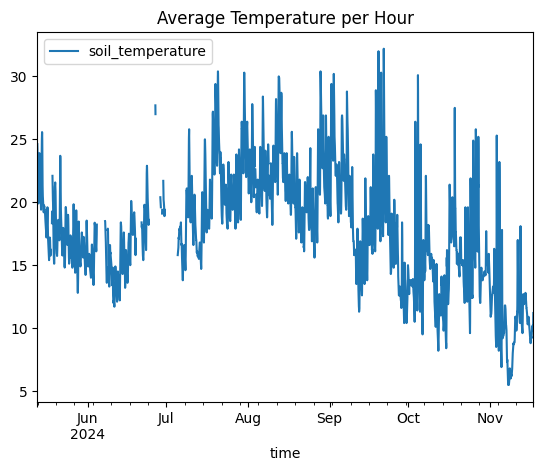

In [26]:
soilTemperature_per_hour = soilTemperature.resample('h', on='time').agg({
    'soil_temperature': 'mean',
})

soilTemperature_per_hour.plot(y='soil_temperature', kind='line', title='Average Temperature per Hour')
plt.show()

### Explore correlation between worm count and environment variables

In [27]:
merged_data = pd.merge(bme680_per_hour, worms_per_hour, left_index=True, right_index=True)
merged_data = pd.merge(merged_data, soilMoisture_per_hour, left_index=True, right_index=True)
merged_data = pd.merge(merged_data, soilTemperature_per_hour, left_index=True, right_index=True)
merged_data.head()

,humidity,temperature,pressure,num_worms,hour,adc,soil_temperature
2024-08-26 00:00:00,67.234932,17.448359,1019.433892,0,0,5911.0,17.4
2024-08-26 01:00:00,68.904603,17.193086,1019.385554,0,1,5875.0,16.9
2024-08-26 02:00:00,71.370427,16.823750,1019.305363,0,2,5827.0,16.6
2024-08-26 03:00:00,74.007851,16.594062,1019.199347,0,3,5820.0,16.4
2024-08-26 04:00:00,75.013800,16.296602,1019.219298,0,4,5783.0,16.1


<Axes: >

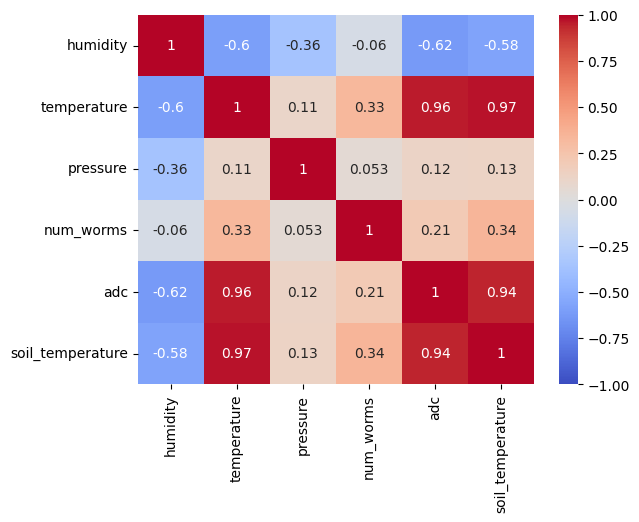

In [28]:
sns.heatmap(
    merged_data[['humidity', 'temperature', 'pressure', 'num_worms', 'adc', 'soil_temperature']].corr(),
    annot=True,
    vmin=-1,
    vmax=1,
    cmap='coolwarm'
)

<Axes: title={'center': 'Number of Worms Detected vs. Temperature'}, xlabel='temperature', ylabel='num_worms'>

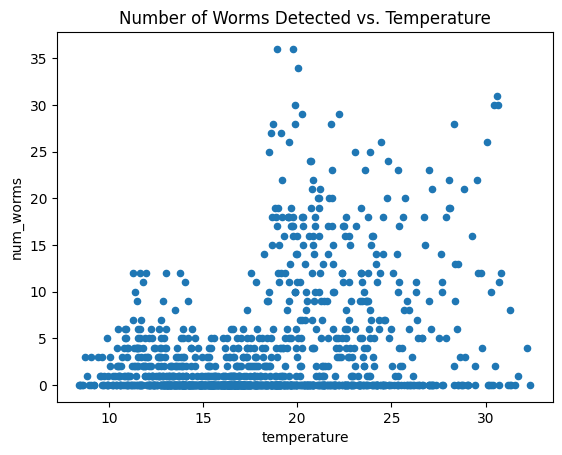

In [29]:
merged_data.plot(kind='scatter', x='temperature', y='num_worms', title='Number of Worms Detected vs. Temperature')

<Axes: title={'center': 'Correlation between Soil Moisture sensor and Temperature'}, xlabel='temperature', ylabel='adc'>

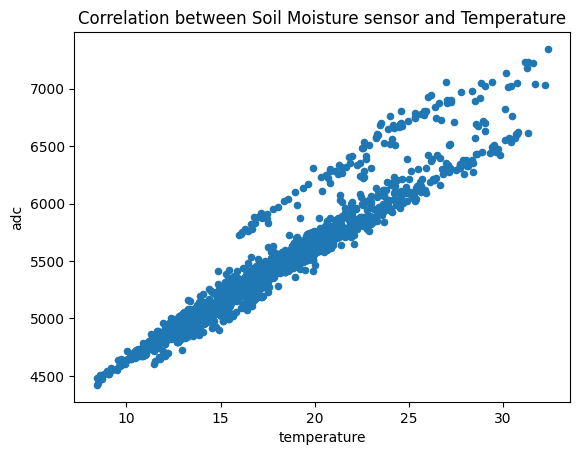

In [30]:
merged_data.plot(kind='scatter', x='temperature', y='adc', title='Correlation between Soil Moisture sensor and Temperature')

#### Check correlation when data resampled by day

In [31]:
merged_data_by_day = merged_data.resample('D').agg({
    'humidity': 'mean',
    'temperature': 'mean',
    'pressure': 'mean',
    'num_worms': 'mean'
})

merged_data_by_day.head()

,humidity,temperature,pressure,num_worms
2024-08-26,67.917740,19.121528,1019.964386,0.000000
2024-08-27,59.886810,22.186657,1019.608628,0.125000
2024-08-28,53.139170,26.059696,1013.876607,0.000000
2024-08-29,63.597650,24.024767,1015.177012,1.916667
2024-08-30,54.239818,22.848278,1021.139572,11.375000


<Axes: >

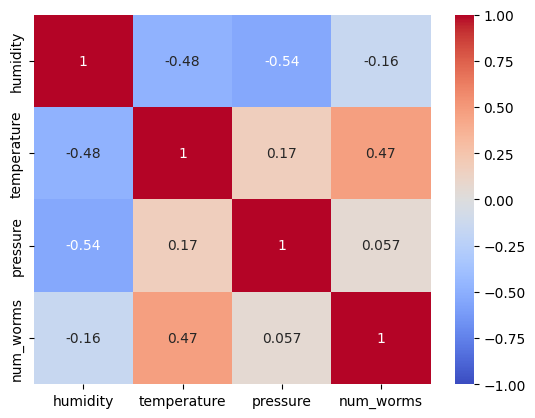

In [32]:
sns.heatmap(
    merged_data_by_day[['humidity', 'temperature', 'pressure', 'num_worms']].corr(),
    annot=True,
    vmin=-1,
    vmax=1,
    cmap='coolwarm'
)

### Explore correlation between daily moisture and humidity shift

#### Soil moisture sensor average for each hour of the day

In general, a higher ADC (Analog-to-Digital Converter) value corresponds to drier soil, while a lower ADC value indicates more moist soil.

In [33]:
soilMoisture_per_hour.loc[:, 'hour'] = soilMoisture_per_hour.index.hour
mean_adc_per_hour = soilMoisture_per_hour.groupby('hour')['adc'].mean().reset_index()

mean_adc_per_hour.head()

,hour,adc
0,0,5506.764151
1,1,5439.323810
2,2,5424.180952
3,3,5412.452830
4,4,5386.858491


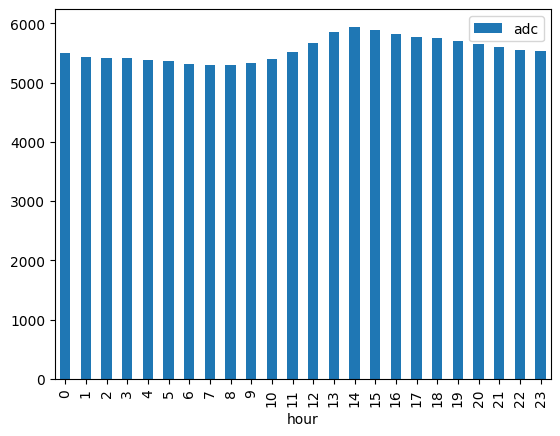

In [34]:
mean_adc_per_hour.plot(x='hour', kind='bar')
plt.show()

In [35]:
merged_hourly_data = pd.merge(mean_adc_per_hour, total_count_per_hour, on='hour')
merged_hourly_data.head()

,hour,adc,num_worms
0,0,5506.764151,184
1,1,5439.323810,231
2,2,5424.180952,240
3,3,5412.452830,179
4,4,5386.858491,190


<Axes: >

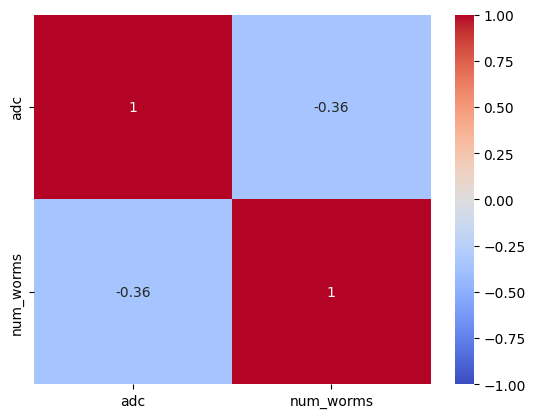

In [36]:
sns.heatmap(
    merged_hourly_data[['adc', 'num_worms']].corr(),
    annot=True,
    vmin=-1,
    vmax=1,
    cmap='coolwarm'
)

#### Air moisture sensor average for each hour of the day

In [37]:
# Group by hour of the day and sum the number of worms detected
bme680_sept_oct.loc[:, 'hour'] = bme680_sept_oct.index.hour
mean_humidity_per_hour = bme680_sept_oct.groupby('hour')['humidity'].mean().reset_index()

mean_humidity_per_hour.head()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,hour,humidity
0,0,75.420922
1,1,76.545829
2,2,77.249731
3,3,77.987340
4,4,78.457787


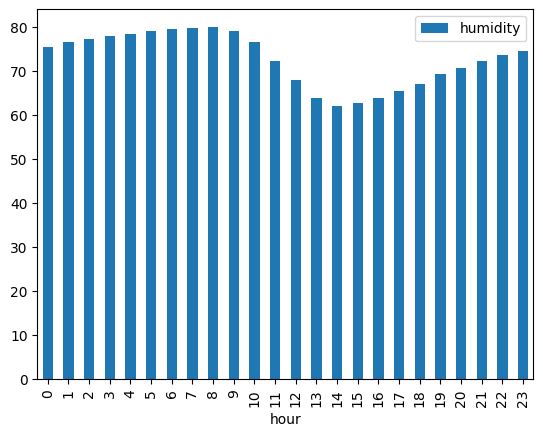

In [38]:
mean_humidity_per_hour.plot(x='hour', kind='bar')
plt.show()

In [39]:
merged_hourly_data = pd.merge(mean_humidity_per_hour, total_count_per_hour, on='hour')
merged_hourly_data.head()

,hour,humidity,num_worms
0,0,75.420922,184
1,1,76.545829,231
2,2,77.249731,240
3,3,77.987340,179
4,4,78.457787,190


<Axes: >

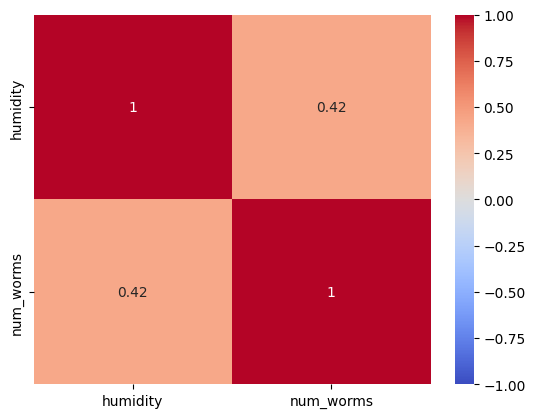

In [40]:
sns.heatmap(
    merged_hourly_data[['humidity', 'num_worms']].corr(),
    annot=True,
    vmin=-1,
    vmax=1,
    cmap='coolwarm'
)